In [1]:
import os
import sys
import time
import shutil
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow import keras


import sklearn.preprocessing

2024-10-20 16:56:59.012528: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 16:56:59.241805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 16:56:59.241924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 16:56:59.288120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 16:56:59.390608: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpu,
#                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
#     except RuntimeError as e:
#         print(e)

In [3]:
def get_dataset(directory, single_file=False, use_half=False, section=1, use_num_files=False, num_files=100):  
    if single_file:
        df = pd.read_csv(directory, index_col='timestamp')
        df.dropna(inplace=True)
        return df
    
    merged_df = pd.DataFrame()
    list_files = os.listdir(directory)
    print(len(list_files))
    if use_num_files:
        for i in range(num_files):
            df = pd.read_csv(os.path.join(directory, list_files[i]), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)

    if use_half:
        for i, files in enumerate(list_files):
            if section==1:
                if i > len(list_files) //2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
            if section==2:
                if i <= len(list_files) // 2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
    else:
        for files in list_files:
            df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # print(i)
    return merged_df

In [4]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables), dtype='float32')

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [5]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [6]:
def calculate_time_shift(df, variable, gamma=0.9, label_col='class'):
    min_val = df[variable].min()
    max_val = df[variable].max()
    df['normalized_var'] = (df[variable] - min_val) / (max_val - min_val)

    threshold_value = gamma
    shift_index = df.index[df['normalized_var'] >= threshold_value][0]

    df_shifted = df.copy()
    df_shifted[label_col] = 0 
    df_shifted.loc[shift_index:, label_col] = 1

    df_shifted.drop(columns=['normalized_var'], inplace=True)
    df.drop(columns=['normalized_var'], inplace=True)

    return df_shifted

In [7]:
# def calculate_reconstruction_loss(data, reconstructions):
#     reconstruction_errors = np.mean(np.square(data - reconstructions), axis=1)
#     total_r_e = np.sum(reconstruction_errors)
#     relative_reconstruction_errors = np.array([(r_e / total_r_e) * 100 for r_e in reconstruction_errors])
#     return relative_reconstruction_errors

def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    total_r_e = np.sum(reconstruction_errors)
    relative_reconstruction_errors = np.array([(r_e / total_r_e) * 100 for r_e in reconstruction_errors])
    return reconstruction_errors

In [8]:
# def find_optimal_threshold(reconstruction_errors, y_true, num_steps=500):
#     # Initialize variables
#     best_f1 = 0
#     best_upper_threshold = 0
#     best_lower_threshold = 0
#     best_y_pred = None
    
#     # Calculate median, mean, and max of reconstruction errors
#     q1 = np.percentile(reconstruction_errors, 25)
#     q3 = np.percentile(reconstruction_errors, 75)
#     max_error = np.max(reconstruction_errors)
#     min_error = -1 * max_error
    
#     # Define search ranges for upper and lower thresholds
#     upper_search_range = np.linspace(q3, max_error, num=num_steps)
#     lower_search_range = np.linspace(q1, min_error, num=num_steps)
    
#     # Iterate over both thresholds in parallel
#     for upper_threshold, lower_threshold in zip(upper_search_range, lower_search_range):
#         if upper_threshold > lower_threshold:  # Ensure valid threshold combination
#             # Get y_pred based on the current thresholds
#             y_pred = np.where((reconstruction_errors > upper_threshold) | (reconstruction_errors < lower_threshold), 1, 0)
            
#             # Calculate F1-score
#             current_f1 = f1_score(y_true.astype(bool), y_pred.astype(bool))
            
#             # Update if a better F1-score is found
#             if current_f1 > best_f1:
#                 best_f1 = current_f1
#                 best_upper_threshold = upper_threshold
#                 best_lower_threshold = lower_threshold
#                 best_y_pred = y_pred

#     threshold_range = best_upper_threshold - best_lower_threshold
#     # Iterate over possible starting points for the lower threshold
#     for lower_threshold in np.linspace(min_error, max_error - threshold_range, num=num_steps):
#         upper_threshold = lower_threshold + threshold_range

#         if upper_threshold > max_error:  # Ensure valid upper threshold
#             break

#         # Generate predictions for the current threshold range
#         y_pred = np.where((reconstruction_errors > upper_threshold) | (reconstruction_errors < lower_threshold), 1, 0)

#         # Calculate F1-score
#         current_f1 = f1_score(y_true.astype(bool), y_pred.astype(bool))

#         # Update if a better F1-score is found
#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_upper_threshold = upper_threshold
#             best_lower_threshold = lower_threshold
#             best_y_pred = y_pred

#     return best_upper_threshold, best_lower_threshold, best_f1, best_y_pred


In [9]:
def find_optimal_threshold(reconstruction_errors, y_true):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score

    best_threshold = 0.0
    best_f1 = 0.0
    best_y_pred = np.zeros(reconstruction_errors.shape)
    # q3 = np.percentile(reconstruction_errors, 75)
    # q1 = np.percentile(reconstruction_errors, 25)
    # iqr = q3 - q1
    upper_bound = np.max(reconstruction_errors)
    lower_bound = np.min(reconstruction_errors)

    thresholds = np.linspace(lower_bound, upper_bound, num=1000)

    for threshold in thresholds:
        y_pred = np.where((reconstruction_errors > threshold) ,1, 0)
        # print(y_pred.shape)
        # print(y_true.shape)

        # Hitung F1-Score
        current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_y_pred = y_pred

    return best_threshold, best_f1, best_y_pred

In [10]:
# def find_optimal_threshold(reconstruction_errors, y_true):
#     from sklearn.metrics import accuracy_score, balanced_accuracy_score

#     best_threshold = 0.0
#     best_f1 = 0.0
#     best_y_pred = np.zeros(reconstruction_errors.shape)
#     q3 = np.percentile(reconstruction_errors, 75)
#     q1 = np.percentile(reconstruction_errors, 25)
#     iqr = q3 - q1
#     upper_bound = max(np.max(reconstruction_errors) / 2, (q3 + iqr * 1.5))
#     lower_bound = min(np.min(reconstruction_errors) / 2, (q1 - iqr * 1.5))

#     thresholds = np.linspace(lower_bound, upper_bound, num=500)

#     for threshold in thresholds:
#         y_pred = np.where(
#             (reconstruction_errors > (threshold + iqr)) | 
#             (reconstruction_errors < (threshold - iqr)),
#               1, 0)
#         # print(y_pred.shape)
#         # print(y_true.shape)

#         # Hitung F1-Score
#         current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_threshold = threshold
#             best_y_pred = y_pred

#     return best_threshold, best_f1, best_y_pred

In [10]:
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

def visualize_instance(source):
    df = pd.read_csv(source, index_col='timestamp')
    df_class = df[['class']]
    class_type = df['class'].unique()

    for col in df.columns:
        scaler = MinMaxScaler()
        scaler.fit(df[col].values.reshape(-1, 1))
        df[col] = scaler.transform(df[col].values.reshape(-1, 1))
    
    legends = list(df.columns)
    legends.extend(['normal','transient', 'fault'])

    plt.figure(figsize=(16, 8))    
    # plt.plot(df)
    # plt.xlabel('timestamp')
    # plt.ylabel('scaled')
    df.plot(figsize=(16, 8))

    xmin, xmax, ymin, ymax = plt.axis()
    
    colors = ['green', 'yellow', 'red']
    for i in range(len(class_type)):
        plt.fill_between(df.index, ymax, where=(df_class['class'] == class_type[i]), color=colors[i], alpha=0.3)
    # plt.fill_between(df.index, ymax, where=(i_class['class'] == class_type[1]), color='red', alpha=0.3)
    # plt.fill_between(df.index, ymax, where=(i_class['class'] == class_type[2]), color='yellow', alpha=0.3)
    plt.legend(legends)
    plt.grid()
    plt.title(f"{os.path.split(source)[0]}-{os.path.split(source)[1]}")
    plt.show()

### Training

In [12]:
merged_df = pd.read_csv("../../filtered_dataset/train/selected_instance_0.csv", index_col='timestamp')
merged_df = merged_df[:300000]

In [13]:
# merged_df = get_dataset('../../datasets/3W/dataset_processed/splitted/0/train')
# merged_df = merged_df.sort_index()
merged_data_class = merged_df['class']

merged_data_np = merged_df.drop('class', axis=1).values

In [14]:
merged_data_np.shape

(300000, 4)

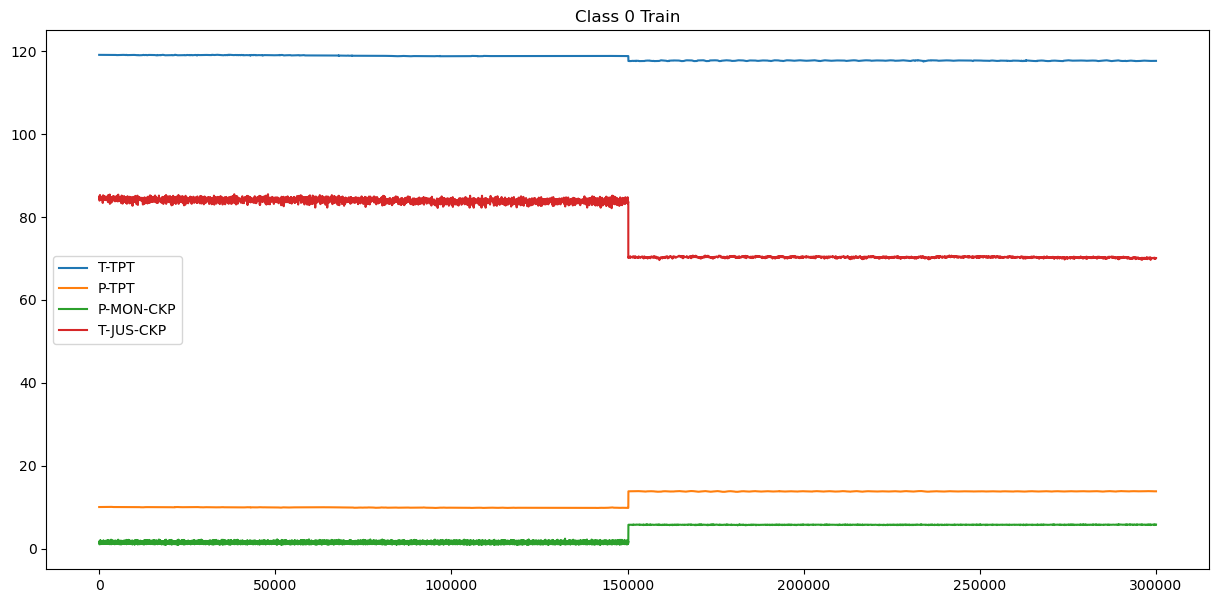

In [13]:
plt.figure(figsize=(15,7))
plt.plot(merged_data_np)
plt.legend(['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP'])
plt.title("Class 0 Train")
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler
import pickle

scaler = pickle.load(open('StandardScaler-3W-0-filtered.pkl', 'rb'))
merged_data_np_scaled = scaler.transform(merged_data_np)

In [16]:
merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)
# merged_data_np_3d = convert_time_window(merged_data_np[:150000, :], 20)
# merged_data_np_3d = convert_time_window(merged_data_np[:150000, :], 5)

In [40]:
merged_data_np_3d.dtype

dtype('float32')

In [16]:
merged_data_np_3d.shape

(299991, 10, 4)

In [17]:
merged_df_2 = pd.read_csv("../../filtered_dataset/train/selected_instance_2.csv", index_col='timestamp')

merged_data_class_2 = merged_df_2['class']
merged_data_np_2 = merged_df_2.drop('class', axis=1).values

scaler = pickle.load(open('StandardScaler-3W-2-filtered.pkl', 'rb'))
merged_data_np_scaled_2 = scaler.transform(merged_data_np_2)

merged_data_np_3d_2 = convert_time_window(merged_data_np_scaled_2, 10)

In [18]:
merged_data_np_3d_2.shape

(53991, 10, 4)

In [19]:
np.array([merged_data_np_3d, merged_data_np_3d]).shape

(2, 299991, 10, 4)

In [21]:
tf_dataset_path = "../../tf_dataset/3W/LSTM-Autoencoder/0_0-300k_2"

merged_all_data_np_3d = np.concatenate((merged_data_np_3d, merged_data_np_3d_2))
dataset = tf.data.Dataset.from_tensor_slices((merged_all_data_np_3d, merged_all_data_np_3d))
dataset = dataset.batch(64)
dataset = dataset.shuffle(merged_all_data_np_3d.shape[0])
tf.data.Dataset.save(dataset, tf_dataset_path)

### =========================================================

In [11]:
def create_lstm_autoencoder(timesteps, n_features):
    # Encoder
    input_layer = keras.layers.Input(shape=(timesteps, n_features))
    encoder = keras.layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = keras.layers.LSTM(64, return_sequences=True)(encoder)
    encoder = keras.layers.LSTM(32, return_sequences=True)(encoder)
    encoder = keras.layers.Flatten()(encoder)
    encoder = keras.layers.Dense(24, activation='relu')(encoder)
    encoder = keras.layers.Dense(10, activation='relu')(encoder)

    decoder = keras.layers.Dense(10, activation='relu')(encoder)
    decoder = keras.layers.Dense(24, activation='relu')(decoder)
    decoder = keras.layers.RepeatVector(timesteps)(decoder)

    decoder = keras.layers.LSTM(32, return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(64, return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(128, return_sequences=True)(decoder)

    decoded_output = keras.layers.TimeDistributed(keras.layers.Dense(n_features))(decoder)

    # Define the full autoencoder model
    autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded_output, name="Autoencoder")

    return autoencoder

# def create_lstm_autoencoder(timesteps, n_features):
#     input_layer = keras.layers.Input(shape=(timesteps, n_features))
#     encoder = keras.layers.LSTM(64, return_sequences=True)(input_layer)
#     encoder = keras.layers.LSTM(32, return_sequences=False)(encoder)

#     decoder = keras.layers.RepeatVector(timesteps)(encoder)
#     decoder = keras.layers.LSTM(32, return_sequences=True)(decoder)
#     decoder = keras.layers.LSTM(64, return_sequences=True)(decoder)
#     output_layer = keras.layers.TimeDistributed(keras.layers.Dense(n_features))(decoder)

#     model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="LSTM-Autoencoder")
#     return model

In [12]:
# To create new model
lstm_model = create_lstm_autoencoder(10, 4)
lstm_model.summary()

2024-10-20 16:57:59.937715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-20 16:58:00.353808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-20 16:58:00.353847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-20 16:58:00.357292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-20 16:58:00.357368: I external/local_xla/xla/stream_executor

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           68096     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            12416     
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 24)                7704      
                                                                 
 dense_1 (Dense)             (None, 10)                

In [12]:
# To re-train model
lstm_model = tf.keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5")
lstm_model.summary()

2024-10-10 12:10:01.486881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 12:10:01.539596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 12:10:01.539643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 12:10:01.541290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-10 12:10:01.541360: I external/local_xla/xla/stream_executor

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           68096     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 24)            

In [13]:
# To use available dataset
tf_dataset_path = "../../tf_dataset/3W/LSTM-Autoencoder/0_0-300k_2"
dataset = tf.data.Dataset.load(tf_dataset_path)

In [14]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, mode='min')
    model_path = os.path.join(log_dir,'best_model.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', mode='min', verbose=1, save_best_only=False)
    return [tensorboard_callback, early_stopping, mc]

In [21]:
lstm_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

In [22]:
log_dir = "../../models/3W/LSTM-Autoencoder/models_LSTM-128-64-32_flatten_latent-24-10_t-10_lr-1e-3_batch-64_merged-data"

In [23]:
history = lstm_model.fit(dataset, callbacks=myCallbacks(log_dir=log_dir), epochs=20)

Epoch 1/20
5531/5531 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.8028
Epoch 1: saving model to ../../models/3W/LSTM-Autoencoder/models_LSTM-128-64-32_flatten_latent-24-10_t-10_lr-1e-3_batch-64_merged-data/best_model.h5
5531/5531 [==============================] - 167s 29ms/step - loss: 0.0238 - accuracy: 0.8028
Epoch 2/20
5531/5531 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.8368
Epoch 2: saving model to ../../models/3W/LSTM-Autoencoder/models_LSTM-128-64-32_flatten_latent-24-10_t-10_lr-1e-3_batch-64_merged-data/best_model.h5
5531/5531 [==============================] - 166s 30ms/step - loss: 0.0155 - accuracy: 0.8368
Epoch 3/20
5531/5531 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.8477
Epoch 3: saving model to ../../models/3W/LSTM-Autoencoder/models_LSTM-128-64-32_flatten_latent-24-10_t-10_lr-1e-3_batch-64_merged-data/best_model.h5
5531/5531 [==============================] - 161s 29ms/step - loss: 0.0

### Find Global Threshold

In [ ]:
data_dir = "../../filtered_dataset/train"
lstm_model = keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-128-64-32_flatten_latent-24-10_t-10_lr-1e-5_batch-64/best_model.h5")

for data_file in os.listdir(data_dir):
    merged_df = pd.read_csv(os.path.join(data_dir, data_file), index_col='timestamp')    
    merged_data_np = merged_df.drop('class', axis=1).values
    merged_data_np_3d = convert_time_window(merged_data_np, 20)

    # FIND GLOBAL THRESHOLD
    train_3d_np = lstm_model.predict(merged_data_np_3d)
    train_2d_np = inverse_convert_time_window(train_3d_np)


    r_e = calculate_reconstruction_loss(merged_data_np, train_2d_np)
    # pd.DataFrame(r_e).to_csv(os.path.join("../../reconstruction_error/LSTM-Autoencoder", data_file), index=False)

In [24]:
data_dir = "../../filtered_dataset/train/selected_instance_0.csv"
lstm_model = keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-128-64-32_flatten_latent-24-10_t-10_lr-1e-3_batch-64_merged-data/best_model.h5")


merged_df = pd.read_csv(data_dir, index_col='timestamp')    
merged_data_np = merged_df.drop('class', axis=1).values

scaler = pickle.load(open('StandardScaler-3W-0-filtered.pkl', 'rb'))
merged_data_np_scaled = scaler.transform(merged_data_np[:300000, :])
merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)

# FIND GLOBAL THRESHOLD
train_3d_np = lstm_model.predict(merged_data_np_3d)
train_2d_np = inverse_convert_time_window(train_3d_np)



9375/9375 [==============================] - 89s 9ms/step


In [25]:

r_e = calculate_reconstruction_loss(merged_data_np_scaled, train_2d_np)
# pd.DataFrame(r_e).to_csv(os.path.join("../../reconstruction_error/LSTM-Autoencoder", "selected_instance_0.csv"), index=False)

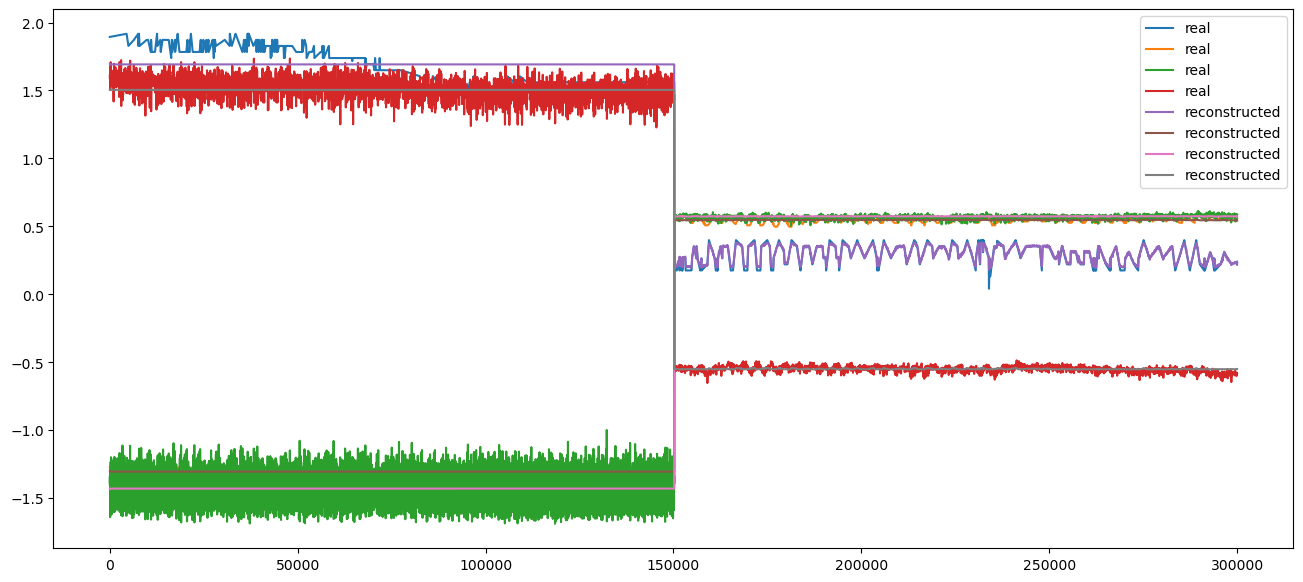

In [26]:
plt.figure(figsize=(16,7))
# plt.plot(inverse_convert_time_window(merged_data_np_3d))
plt.plot(merged_data_np_scaled, label=["real" for _ in range(merged_data_np_scaled.shape[1])])
plt.plot(train_2d_np, label=["reconstructed" for _ in range(train_2d_np.shape[1])])
plt.legend()
plt.show()

In [27]:
print("Max: ", np.max(r_e))
print("Min: ", np.min(r_e))
print("Avg: ", np.mean(r_e))
print("Median: ", np.median(r_e))
print("75%: ", np.percentile(r_e, 75))
print("25%: ", np.percentile(r_e, 25))
print("IQR: ", np.percentile(r_e, 75) - np.percentile(r_e, 25))

Max:  1.4971379306093722
Min:  0.0002902945209001945
Avg:  0.041798855420450184
Median:  0.026170274592726507
75%:  0.07075938625620123
25%:  0.011573795973684966
IQR:  0.05918559028251627


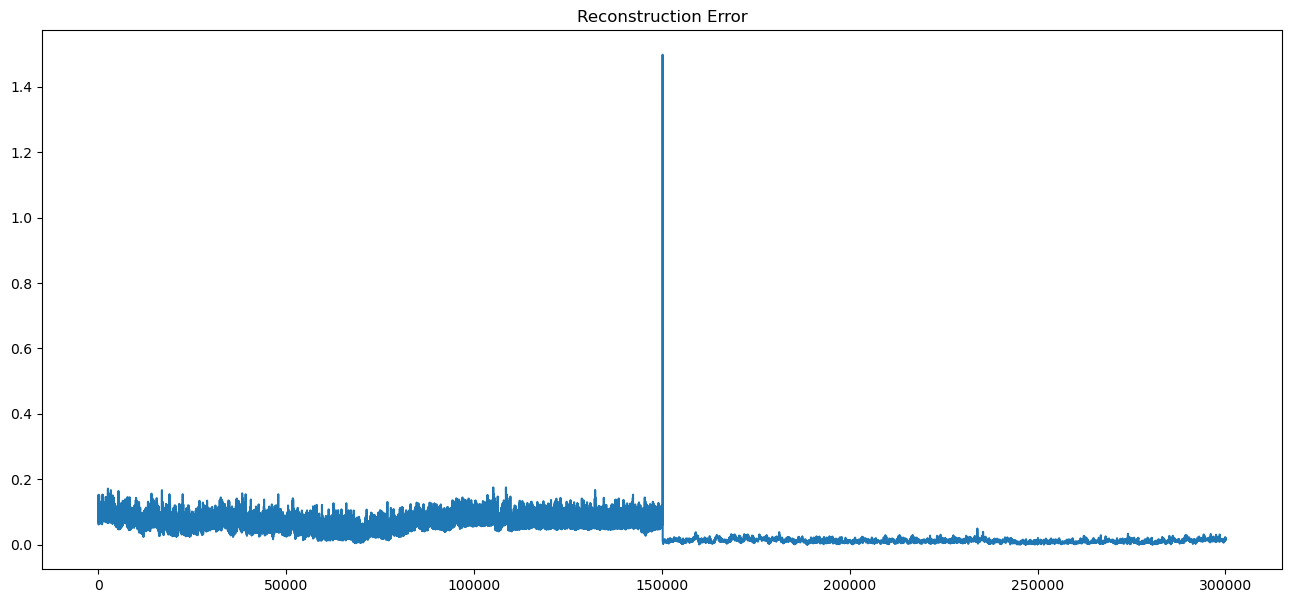

In [28]:
plt.figure(figsize=(16,7))
plt.plot(r_e)
plt.title("Reconstruction Error")
plt.show()

In [24]:
data_dir = "../../filtered_dataset/train/selected_instance_2.csv"
lstm_model = keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-32-32-16_flatten_latent-8-4_t-10_batch-64_merged-data/best_model.h5")


merged_df = pd.read_csv(data_dir, index_col='timestamp')    
merged_data_np = merged_df.drop('class', axis=1).values

scaler = pickle.load(open('StandardScaler-3W-2-filtered.pkl', 'rb'))
merged_data_np_scaled = scaler.transform(merged_data_np)
merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)

# FIND GLOBAL THRESHOLD
train_3d_np = lstm_model.predict(merged_data_np_3d)
train_2d_np = inverse_convert_time_window(train_3d_np)


r_e = calculate_reconstruction_loss(merged_data_np_scaled, train_2d_np)
# pd.DataFrame(r_e).to_csv(os.path.join("../../reconstruction_error/LSTM-Autoencoder", "selected_instance_2.csv"), index=False)

1688/1688 [==============================] - 16s 9ms/step


In [25]:
print("Max: ", np.max(r_e))
print("Min: ", np.min(r_e))
print("Avg: ", np.mean(r_e))
print("Median: ", np.median(r_e))
print("75%: ", np.percentile(r_e, 75))
print("25%: ", np.percentile(r_e, 25))
print("IQR: ", np.percentile(r_e, 75) - np.percentile(r_e, 25))

Max:  0.6178181658904089
Min:  0.005269388347182394
Avg:  0.10505170147533065
Median:  0.07341460116752216
75%:  0.15455738437001962
25%:  0.04389360568557338
IQR:  0.11066377868444624


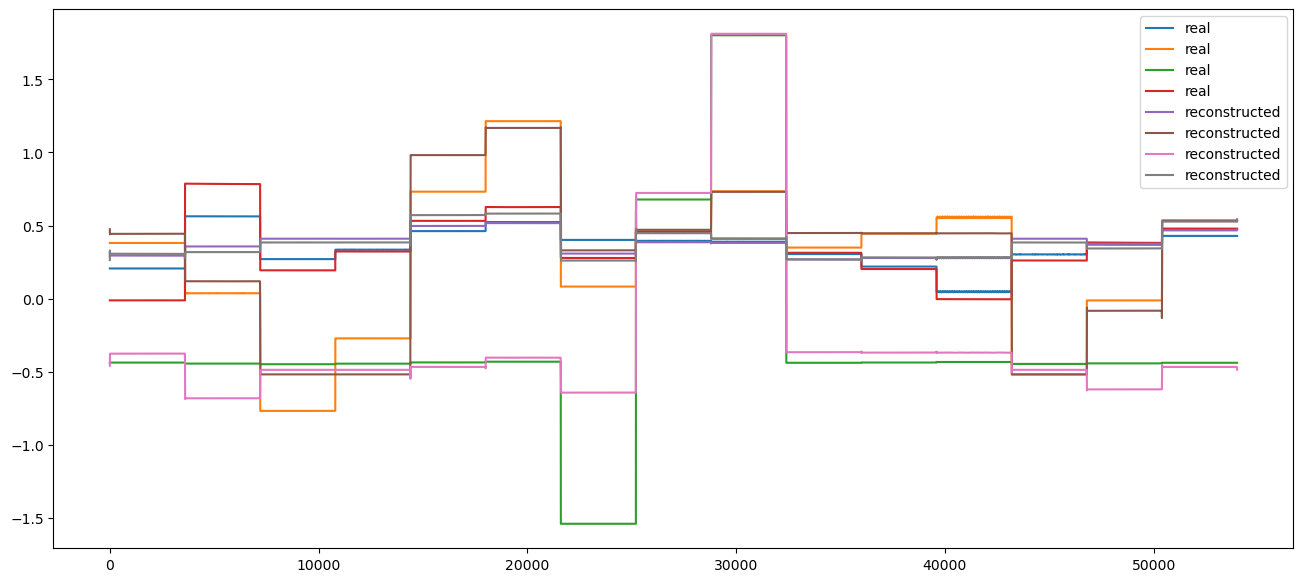

In [26]:
plt.figure(figsize=(16,7))
# plt.plot(inverse_convert_time_window(merged_data_np_3d))
plt.plot(merged_data_np_scaled, label=["real" for _ in range(merged_data_np_scaled.shape[1])])
plt.plot(train_2d_np, label=["reconstructed" for _ in range(train_2d_np.shape[1])])
plt.legend()
plt.show()

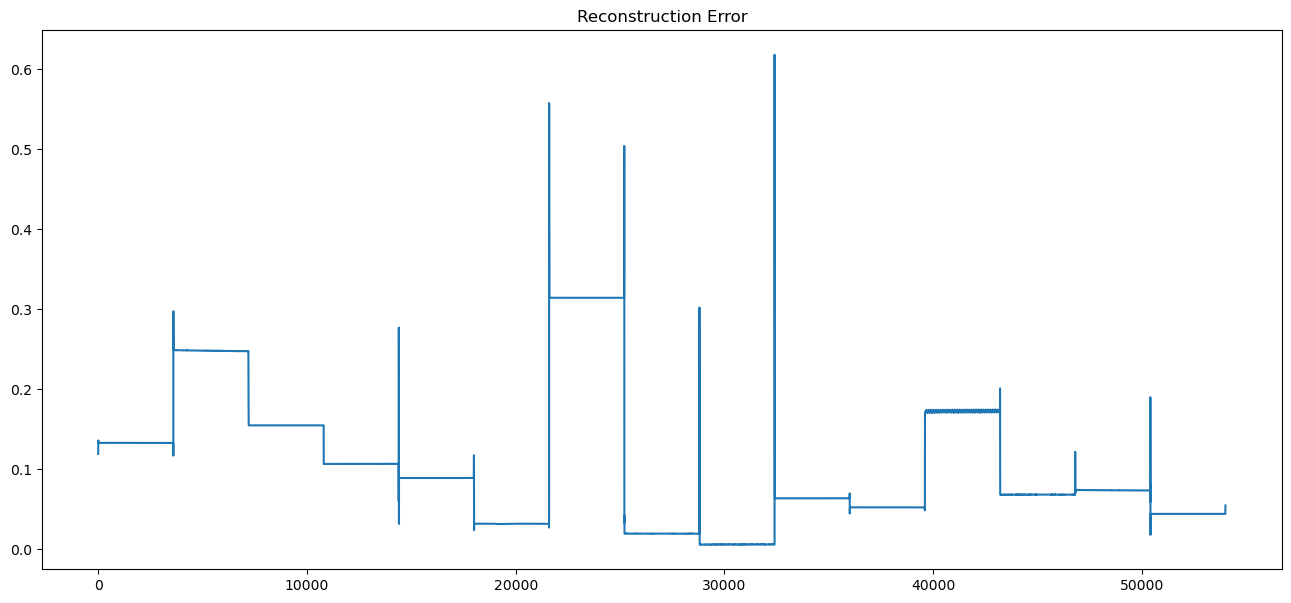

In [27]:
plt.figure(figsize=(16,7))
plt.plot(r_e)
plt.title("Reconstruction Error")
plt.show()

In [31]:
data_dir = "../../filtered_dataset/train/selected_instance_4.csv"
lstm_model = keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-32-16-8_no-dense_t-10_batch-64_merged-data/best_model.h5")


merged_df = pd.read_csv(data_dir, index_col='timestamp')    
merged_data_np = merged_df.drop('class', axis=1).values

scaler = pickle.load(open('StandardScaler-3W-4-filtered.pkl', 'rb'))
merged_data_np_scaled = scaler.transform(merged_data_np)
merged_data_np_3d = convert_time_window(merged_data_np_scaled, 10)

# FIND GLOBAL THRESHOLD
train_3d_np = lstm_model.predict(merged_data_np_3d)
train_2d_np = inverse_convert_time_window(train_3d_np)


r_e = calculate_reconstruction_loss(merged_data_np_scaled, train_2d_np)
# pd.DataFrame(r_e).to_csv(os.path.join("../../reconstruction_error/LSTM-Autoencoder", "selected_instance_4.csv"), index=False)

11471/11471 [==============================] - 106s 9ms/step


In [32]:
print("Max: ", np.max(r_e))
print("Min: ", np.min(r_e))
print("Avg: ", np.mean(r_e))
print("Median: ", np.median(r_e))
print("75%: ", np.percentile(r_e, 75))
print("25%: ", np.percentile(r_e, 25))
print("IQR: ", np.percentile(r_e, 75) - np.percentile(r_e, 25))

Max:  0.8453997875203756
Min:  0.02035790888205026
Avg:  0.23428680088123816
Median:  0.27109352223643673
75%:  0.28913817322314866
25%:  0.24116273441625646
IQR:  0.0479754388068922


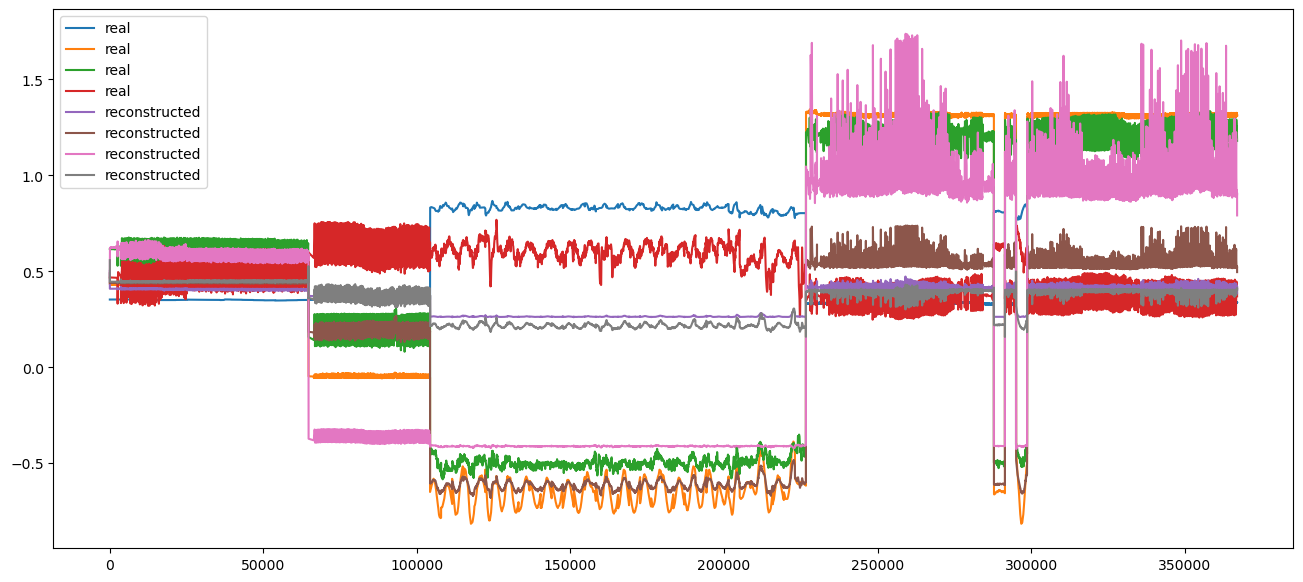

In [33]:
plt.figure(figsize=(16,7))
# plt.plot(inverse_convert_time_window(merged_data_np_3d))
plt.plot(merged_data_np_scaled, label=["real" for _ in range(merged_data_np_scaled.shape[1])])
plt.plot(train_2d_np, label=["reconstructed" for _ in range(train_2d_np.shape[1])])
plt.legend()
plt.show()

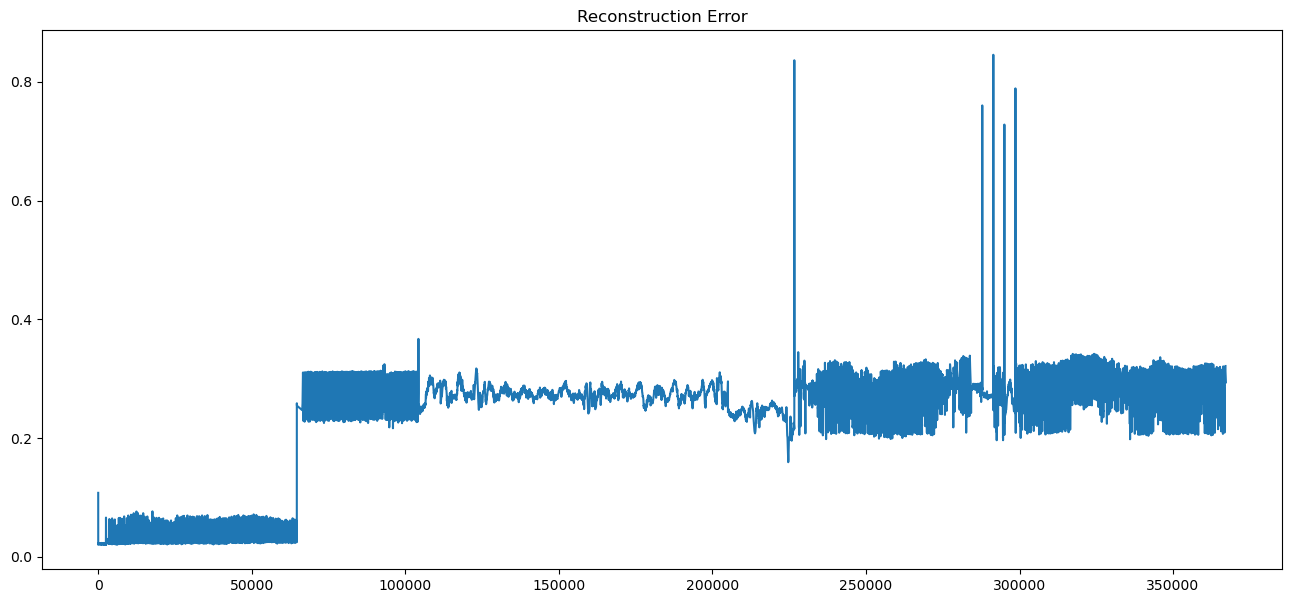

In [34]:
plt.figure(figsize=(16,7))
plt.plot(r_e)
plt.title("Reconstruction Error")
plt.show()

### Testing

In [29]:
dataset_dir = "../../datasets/3W/dataset/2"
list_files = ["SIMULATED_00001.parquet","SIMULATED_00002.parquet","SIMULATED_00003.parquet"]

merged_df_test = pd.DataFrame(columns=['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class'])
for files in list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, files))
    df = df[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']]
    merged_df_test = pd.concat([merged_df_test, df])
# merged_df_test = pd.read_parquet(dataset_dir)
# merged_df_test = merged_df_test[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']]

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in merged_df_test.columns if col.startswith('P')]
merged_df_test[pressure_columns] = merged_df_test[pressure_columns] / 10**6    

# dataset_dir = "../../datasets/3W/dataset_processed/splitted/2/test"

# list_files = os.listdir(dataset_dir)
# file_count = 2

# merged_df_test = pd.DataFrame(columns=['C1','C2','C3','class'])

# for i in range(file_count):
#     df = pd.read_csv(os.path.join(dataset_dir, list_files[i]), index_col='timestamp')
#     df.columns = ['C1','C2','C3','class']
#     merged_df_test = pd.concat([merged_df_test, df], ignore_index=True)

In [26]:
# dataset_dir = "../../datasets/3W/dataset_processed/splitted/0/test"

# list_files = os.listdir(dataset_dir)
# # file_used = 

# merged_df_test = pd.DataFrame(columns=['C1','C2','C3','class'])

# for i in list_files:
#     df = pd.read_csv(os.path.join(dataset_dir, i), index_col='timestamp')
#     df.columns = ['C1','C2','C3','class']
#     merged_df_test = pd.concat([merged_df_test, df], ignore_index=True)

In [30]:
merged_data_test_class = merged_df_test['class']
merged_data_test_np = merged_df_test.drop('class', axis=1).values

merged_data_test_class.fillna(value=0, inplace=True)

In [31]:
# scaler_test = sklearn.preprocessing.StandardScaler()
# scaler_test.fit(merged_data_test_np)

# merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)

# pickle.dump(scaler_test, open('StandardScaler-3W-0-filtered.pkl', 'wb'))

scaler_test = pickle.load(open('StandardScaler-3W-2-filtered.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np_scaled, 10)

In [32]:
merged_data_test_np_3d.dtype

dtype('float32')

In [32]:
merged_data_test_np_3d.shape

(86388, 10, 4)

In [49]:
lstm_model = keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-32-32-16_flatten_latent-8-4_t-10_batch-64_merged-data/best_model.h5")
lstm_model.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4736      
                                                                 
 lstm_1 (LSTM)               (None, 10, 16)            3136      
                                                                 
 lstm_2 (LSTM)               (None, 10, 8)             800       
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 8)                 648       
                                                                 
 dense_1 (Dense)             (None, 4)                 

In [51]:
import time
# lstm_model = keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-32-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5")


start_time = time.time()
pred_3d_np = lstm_model.predict(merged_data_test_np_3d)
end_time = time.time()

# Calculate prediction time
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} seconds")

2700/2700 [==============================] - 24s 9ms/step
Prediction time: 25.193122148513794 seconds


In [35]:
pred_2d = inverse_convert_time_window(pred_3d_np)

In [36]:
pred_2d_inv = scaler_test.inverse_transform(pred_2d)

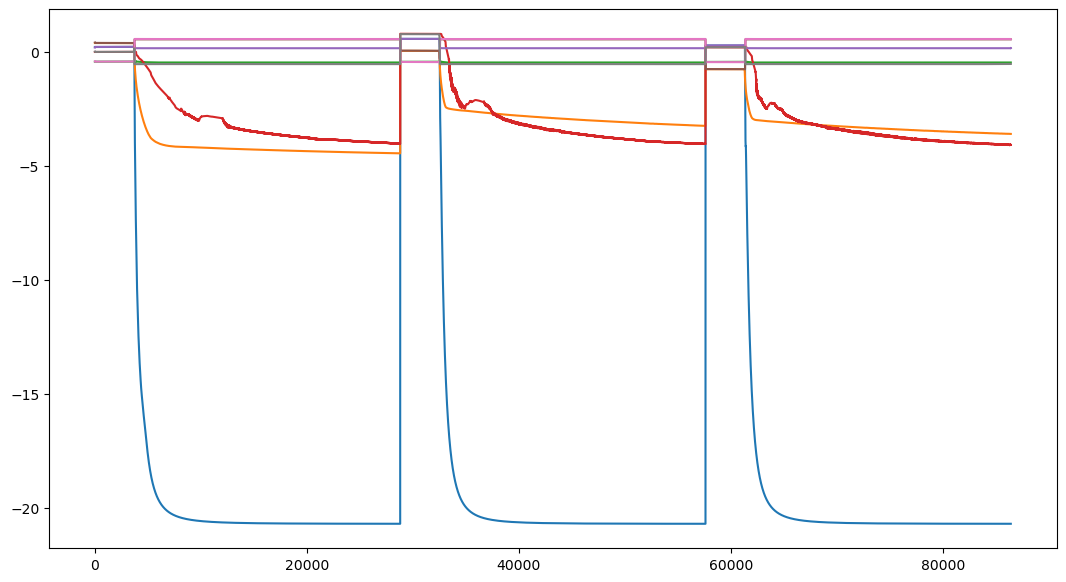

In [37]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np_scaled)
plt.plot(pred_2d)
# plt.legend(['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG'])
# plt.legend(['C1','C2','C3','C1-rec','C2-rec','C3-rec',])
plt.show()

In [45]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, pred_2d)

In [60]:
# thres = 0.0003030413227147653
# thres = 9.390524366278076
# thres = 4.5661401916582
# thres = 0.0050454530076961815
# thres = 1.983172680397427
thres = 1.3821819237963315
if min(r_e) > thres:
    y_pred = np.where((r_e > thres + min(r_e)) ,1, 0)
else:
    y_pred = np.where((r_e > thres) ,1, 0)

In [46]:
thres, f1, y_pred = find_optimal_threshold(r_e, np.array(merged_data_test_class))
print(thres, f1)

0.011049954143969134 0.9974800936398123


In [49]:
thres = 0.6012879803250
y_pred = np.where((r_e > thres) ,1, 0)

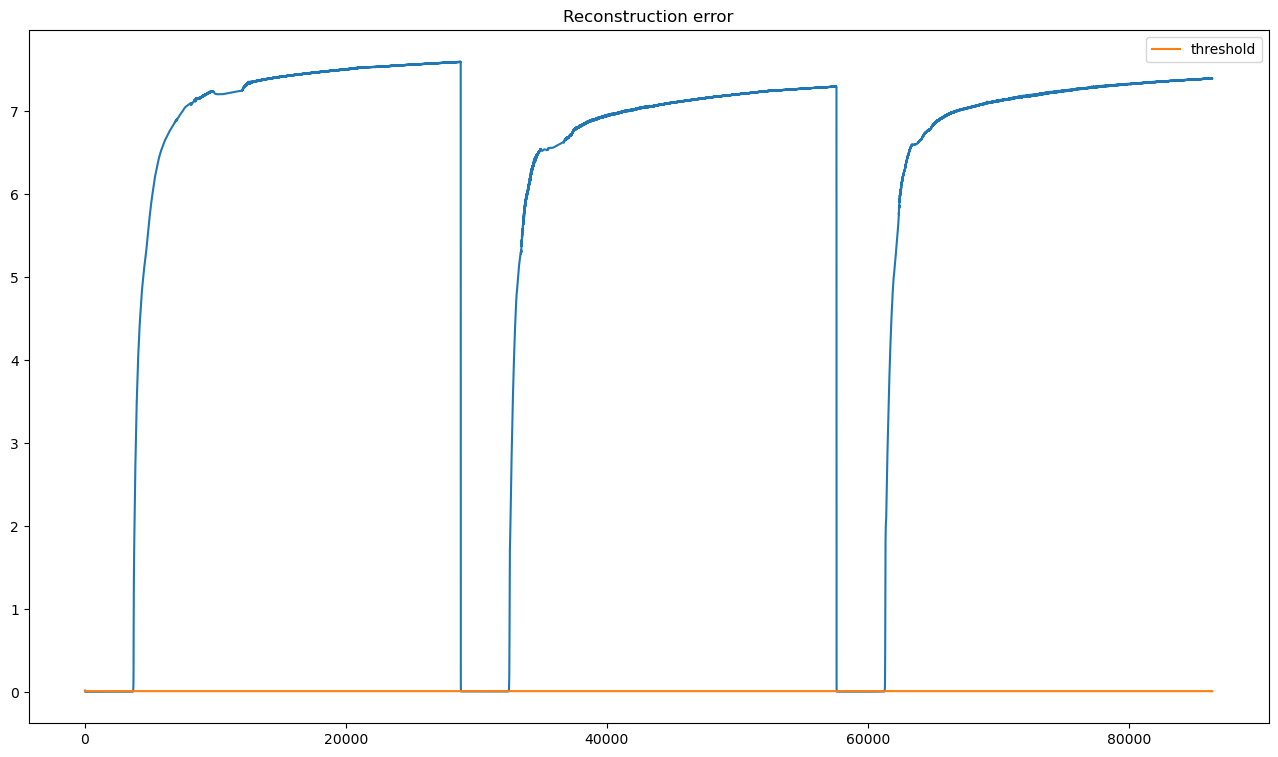

In [47]:
# q3 = np.percentile(r_e, 75)
# q1 = np.percentile(r_e, 25)
# iqr = q3 - q1

plt.figure(figsize=(16,9))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres), label='threshold')
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error")
plt.legend()
plt.show()

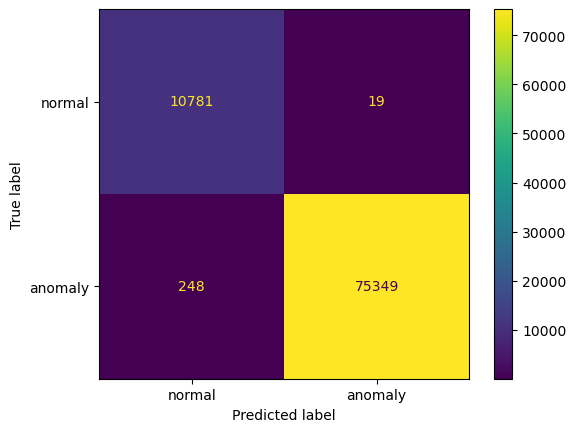

In [41]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(merged_data_test_class).astype(bool), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

In [42]:
print("Accuracy: ", metrics.accuracy_score(np.array(merged_data_test_class).astype(bool), y_pred))
print("F1-score: ", metrics.f1_score(np.array(merged_data_test_class).astype(bool), y_pred))

Accuracy:  0.9969096149171847
F1-score:  0.9982313781340045


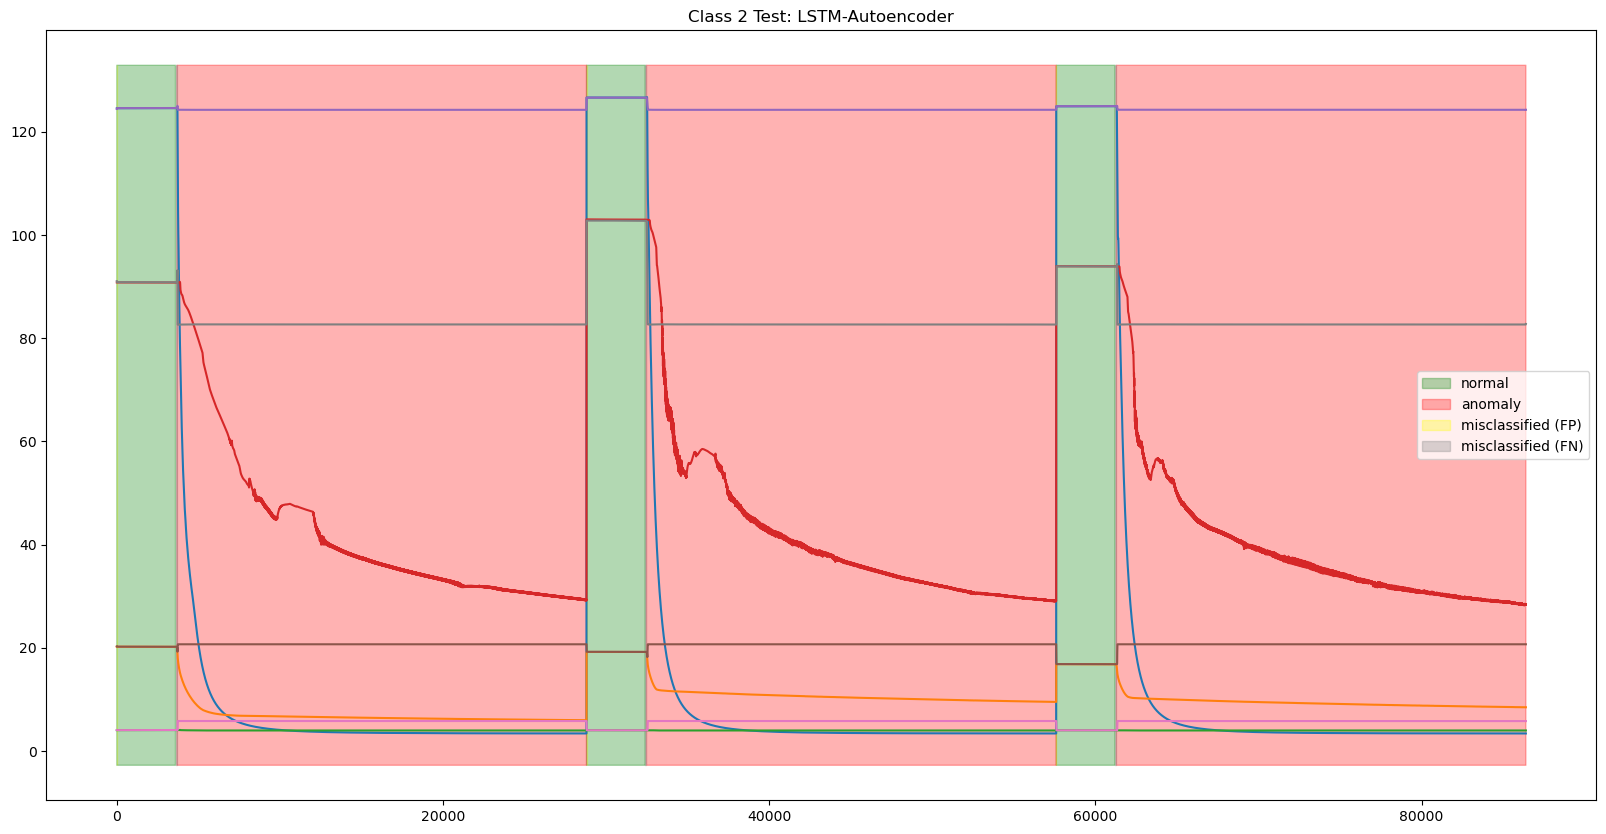

In [43]:
plt.figure(figsize=(20,10))
plt.plot(merged_data_test_np)
plt.plot(pred_2d_inv)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~merged_data_test_class.astype(bool)) & (~y_pred)), color='green', alpha=0.3, label='normal')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=((merged_data_test_class.astype(bool)) & (y_pred)), color='red', alpha=0.3, label='anomaly')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(~merged_data_test_class.astype(bool) & y_pred ), color='yellow', alpha=0.3, label='misclassified (FP)')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(merged_data_test_class.astype(bool) & ~y_pred ), color='gray', alpha=0.3, label='misclassified (FN)')
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied (FP)','missclasiffied (FN)'])
plt.legend()
plt.title("Class 2 Test: LSTM-Autoencoder")
plt.show()

### Smaller size sample testing

In [56]:
sample_test = pd.read_parquet("../../datasets/3W/dataset/1/SIMULATED_00095.parquet")
sample_test = sample_test[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']]

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in sample_test.columns if col.startswith('P')]
sample_test[pressure_columns] = sample_test[pressure_columns] / 10**6   

# sample_test = pd.read_csv('../../datasets/3W/dataset_processed/csv/2/WELL-00011_20141006150121.csv', index_col='timestamp')
# sample_test.dropna(inplace=True)
sample_test['class'].fillna(value=0, inplace=True) 
sample_test_class = sample_test['class']
sample_test_np = sample_test.drop('class',axis=1).values

<Axes: xlabel='timestamp'>

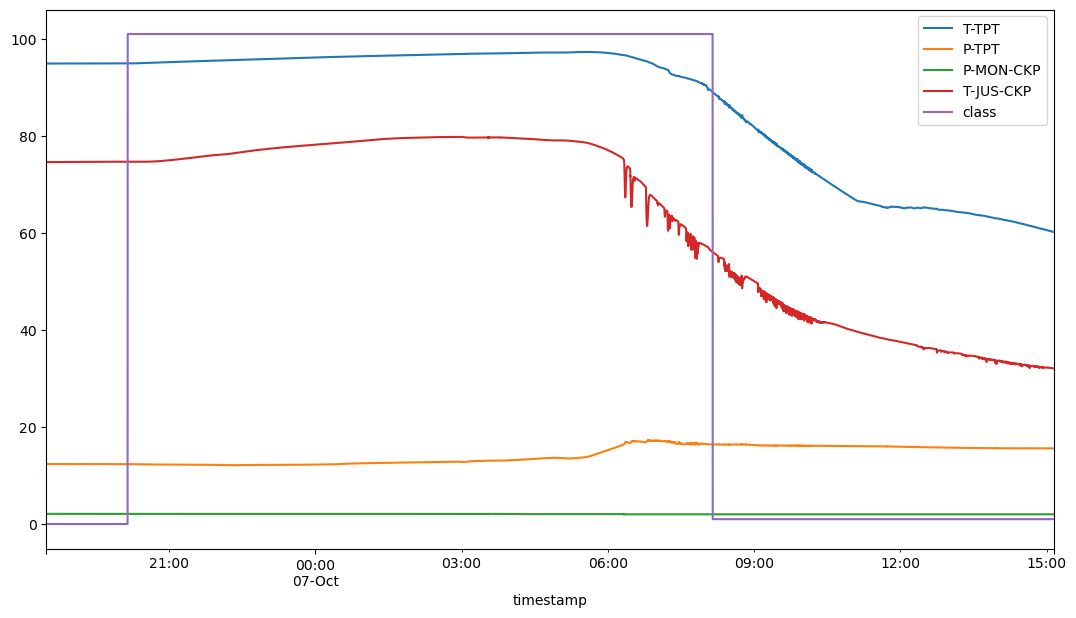

In [57]:
sample_test.plot(figsize=(13,7))

In [59]:
scaler_test = pickle.load(open('./StandardScaler-3W-filtered-0.pkl', 'rb'))
sample_test_np_scaled = scaler_test.transform(sample_test_np)
sample_test_np_3d = convert_time_window(sample_test_np_scaled, 10)

In [60]:
lstm_model = keras.models.load_model("../../models/3W/LSTM-Autoencoder/models_LSTM-32-16-8_no-dense_t-10_batch-64_merged-data/best_model.h5")

pred_3d_np = lstm_model.predict(sample_test_np_3d)

2325/2325 [==============================] - 21s 9ms/step


In [61]:
pred_2d = inverse_convert_time_window(pred_3d_np)

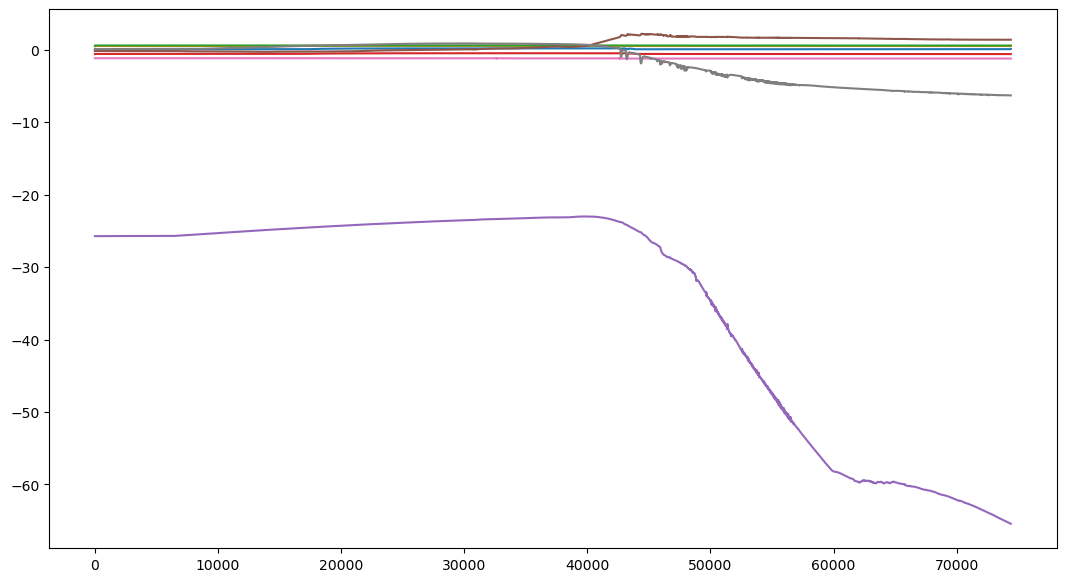

In [62]:
plt.figure(figsize=(13,7))
plt.plot(pred_2d)
plt.plot(sample_test_np_scaled)
plt.show()

In [63]:
sample_r_e = calculate_reconstruction_loss(sample_test_np_scaled, pred_2d)

In [41]:
# thres = 0.0003030413227147653
# thres = 96.47276725479719
# thres = 0.0009091239681442965
# thres = 0.011218145552569274
# thres = 9.390524366278076
# thres = 0.0004109892854972253
# thres = 0.359605087732688
# thres = 4.5661401916582
high_thres = 6.787441900899506
thres = 4.5661401916582
low_thres = 0.359605087732688
# thres = 0.0050454530076961815/
if min(sample_r_e) > high_thres:
    sample_y_pred = np.where((sample_r_e > (thres + min(sample_r_e))) ,1, 0)
else:
    sample_y_pred = np.where((sample_r_e > thres) ,1, 0)

In [69]:
min(sample_r_e)

18.258532286970524

In [64]:
thres, f1, sample_y_pred  = find_optimal_threshold(sample_r_e, sample_test_class)
print(thres, f1)

7.230906725451837 0.7201128671471805


In [21]:
thres = 1.2911670873541246
y_pred = np.where((r_e > thres) ,1, 0)

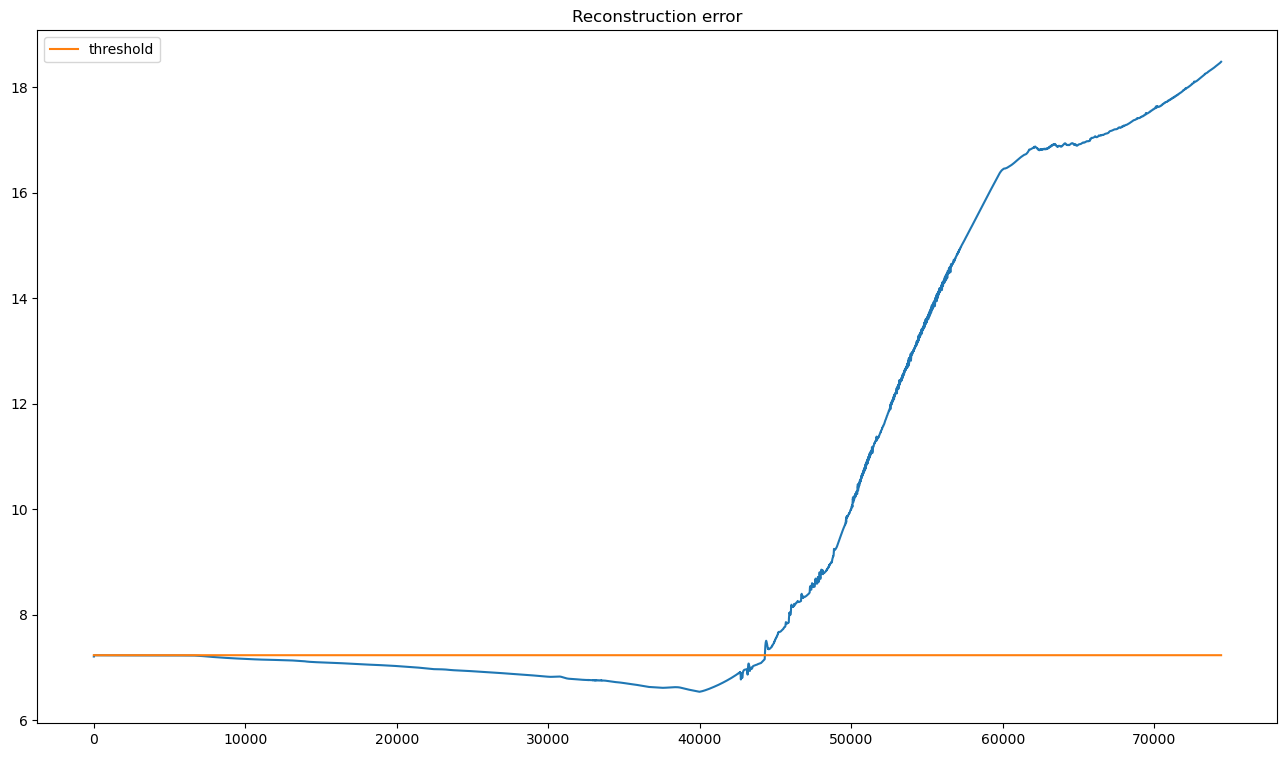

In [66]:
# q3 = np.percentile(sample_r_e, 75)
# q1 = np.percentile(sample_r_e, 25)
# iqr = q3 - q1

plt.figure(figsize=(16,9))
plt.plot(sample_r_e)
plt.plot(np.full(sample_r_e.shape[0], thres), label='threshold')
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), sample_r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error")
plt.legend()
plt.show()

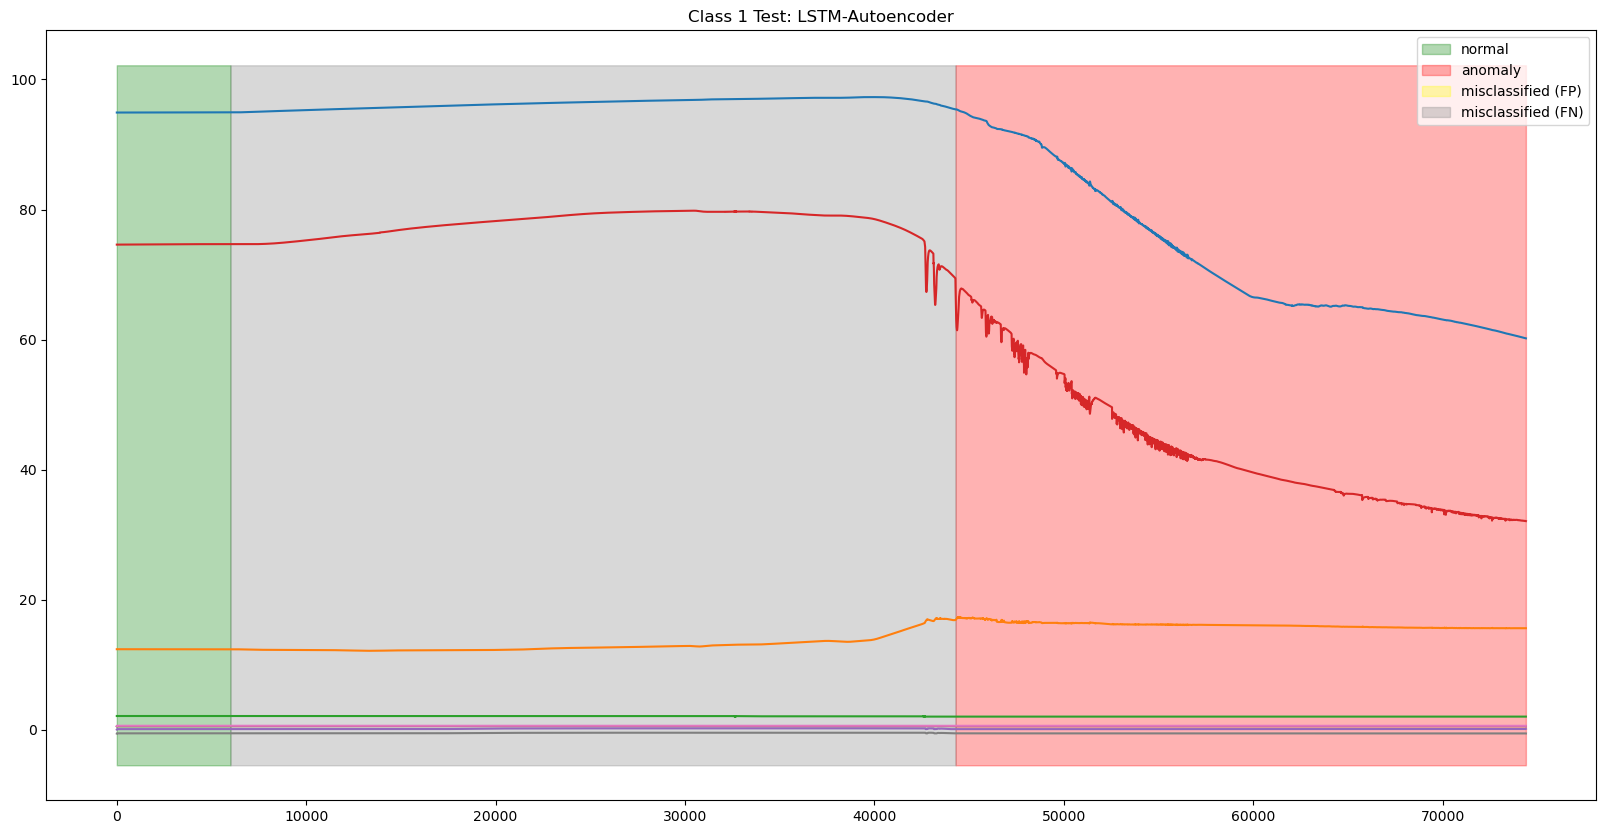

In [67]:
plt.figure(figsize=(20,10))
plt.plot(sample_test_np)
plt.plot(pred_2d)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~sample_test_class.astype(bool)) & (~sample_y_pred)), color='green', alpha=0.3, label='normal')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=((sample_test_class.astype(bool)) & (sample_y_pred)), color='red', alpha=0.3, label='anomaly')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(~sample_test_class.astype(bool) & sample_y_pred ), color='yellow', alpha=0.3, label='misclassified (FP)')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(sample_test_class.astype(bool) & ~sample_y_pred ), color='gray', alpha=0.3, label='misclassified (FN)')
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied [FP]','missclasiffied [FN]'])
plt.legend()
plt.title("Class 1 Test: LSTM-Autoencoder")
plt.show()

In [93]:
print("Accuracy: ", metrics.accuracy_score(np.array(sample_test_class).astype(bool), sample_y_pred))
print("F1-score: ", metrics.f1_score(np.array(sample_test_class).astype(bool), sample_y_pred))

Accuracy:  0.4373714700466404
F1-score:  0.5590958404870496


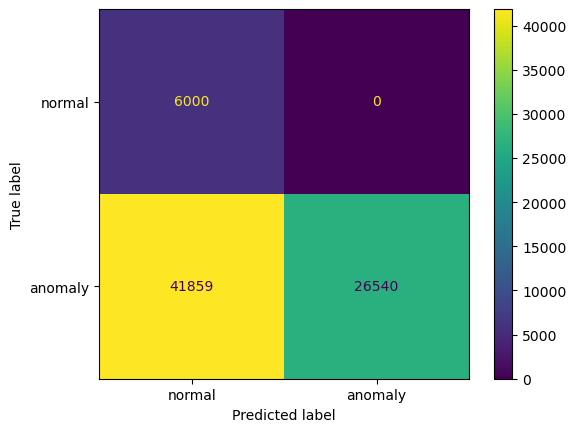

In [94]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(sample_test_class).astype(bool), sample_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

#### Time Shifted

In [38]:
sample_test['class'] = sample_test[['class']].applymap(lambda x: 0 if x == 0 else 1)
sample_test_shifted = calculate_time_shift(sample_test, 'P-PDG')
sample_test_class_shifted = sample_test_shifted['class']

In [46]:
thres, f1, sample_y_pred  = find_optimal_threshold(r_e, sample_test_class)
print(thres, f1)

4.837385793502294e-06 0.9661494613983801


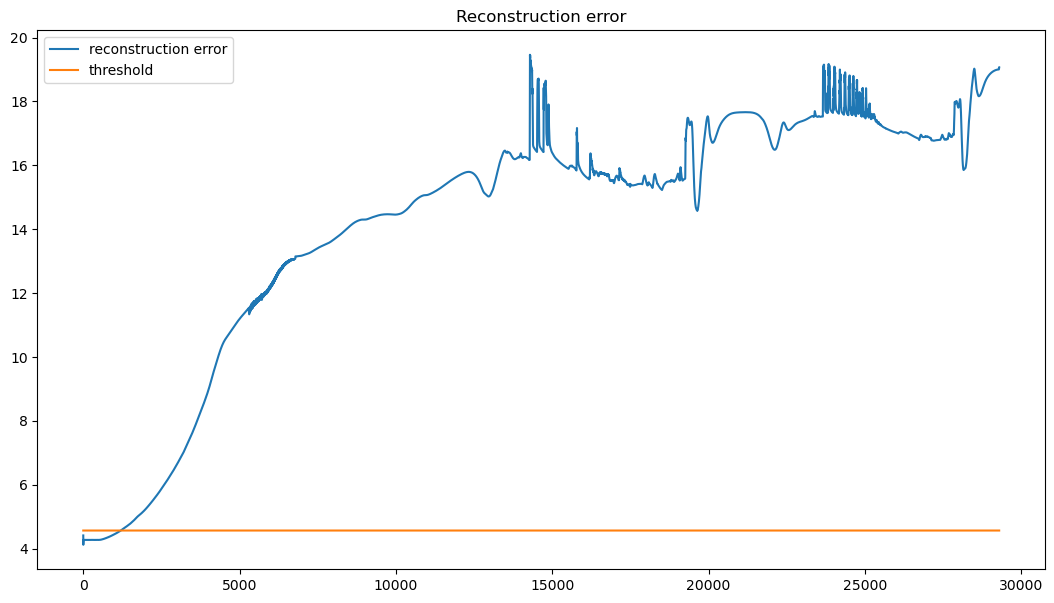

In [39]:
plt.figure(figsize=(13,7))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres))
# plt.plot(np.full(r_e.shape[0], thres_down))
plt.title("Reconstruction error")
plt.legend(["reconstruction error", "threshold"])
plt.show()

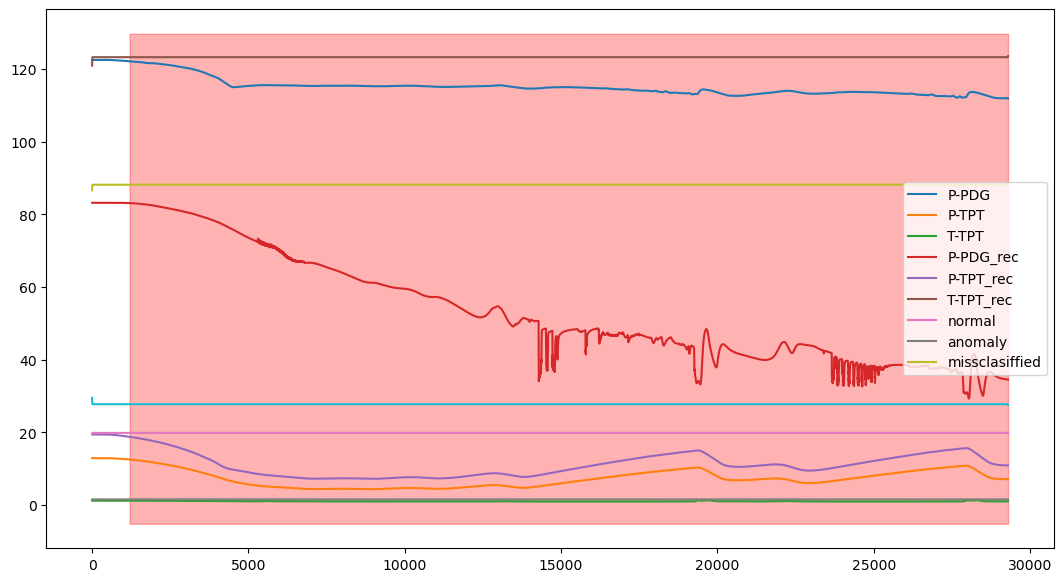

In [40]:
plt.figure(figsize=(13,7))
plt.plot(sample_test_np)
plt.plot(pred_2d)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~sample_test_class_shifted.astype(bool)) & (~sample_y_pred)), color='green', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((sample_test_class_shifted.astype(bool)) & (sample_y_pred)), color='red', alpha=0.3)
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=(~sample_test_class_shifted.astype(bool) & sample_y_pred ), color='yellow', alpha=0.3)
plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied'])
plt.show()

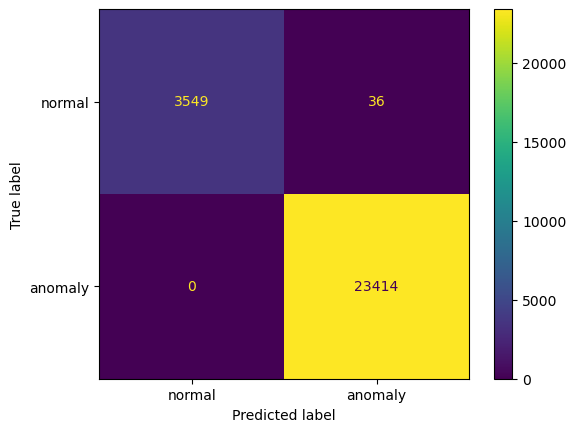

In [33]:
confusion_matrix = metrics.confusion_matrix(np.array(sample_test_class_shifted).astype(bool), sample_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()